In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
import re
def tablelize(star):
    string = star.render_latex().replace("\\begin{table}[!htbp] \\centering","").replace("\\end{table}","").replace("_","\\_")
    return re.sub(r"\(df=[\d; ]*\)", "", string)

<Axes: xlabel='distance', ylabel='Count'>

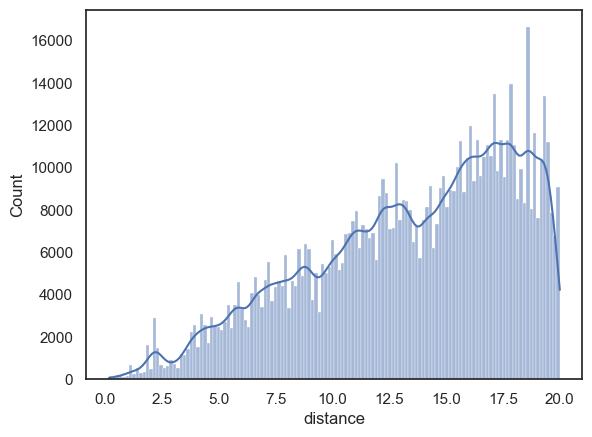

In [5]:
log=np.log
sns.set_theme(style="white")
original_df = pd.read_parquet("../data/olsupsd.parquet")
sns.histplot(original_df["distance"], kde=True)

In [6]:
df = original_df[original_df["保险金额"] > 0].copy()
df["历史投保"] = df["上年保单号"].map(lambda x: 1 if x else 0)
df = df[(df["t"] > 1999) & (df["t"] < 2014)]
df["ti"] = (df["t"]-2000).astype(str)
df["是否理赔"] = df["total_claim"].map(lambda x: 1 if x > 0 else 0)

df.rename(
    columns={
        "保费合计": "Premium",
        "保险金额": "Coverage",
        "middle": "Neighbor",
        "treated": "Disaster",
        "after": "Post",
        "历史投保": "Prem_before",
        "保险财产购置价": "Price",
        "建筑面积": "Area",
        "是否理赔":"Claim",
        "保险密度": "Density",
        "保险深度": "Penetration",
        "gdp": "GDP"
    },
    inplace=True,
)
df["Price"]=df["Price"]/10000
columns = ['Premium', 'Coverage', 'Price', 'Density', 'Penetration', 'GDP']
minmax=[0.025,0.975]
quantiles=df[columns].quantile(minmax)
for column in columns:
    df=df[(df[column]>quantiles.loc[minmax[0], column]) & (df[column]<quantiles.loc[minmax[1], column])]
df=df[df["Price"]>0]
df=df.copy()
# df.to_parquet("../data/df.parquet")
df.head()

,省份,站名,minpost,maxpost,total_claim,下年保单号,Neighbor,区站号,区站经度,区站纬度,...,Premium,Price,Area,t,GDP,Density,Penetration,Prem_before,ti,Claim
8192,浙江,玉环,0.0,0.0,0.0,,0,58667,121.16,28.05,...,850.0,35.0,85.839996,2008,0.144449,390.124768,0.95538,0,8,0
8195,浙江,洪家,299.0,-15.0,0.0,,1,58665,121.25,28.37,...,200.0,40.0,87.889999,2008,0.144449,390.124768,0.95538,0,8,0
8196,浙江,洪家,298.0,-16.0,0.0,,1,58665,121.25,28.37,...,94.5,90.0,118.339996,2008,0.144449,390.124768,0.95538,0,8,0
8197,浙江,洪家,298.0,-16.0,0.0,,1,58665,121.25,28.37,...,315.0,90.0,524.340027,2008,0.144449,390.124768,0.95538,0,8,0
8198,浙江,洪家,298.0,-16.0,0.0,,1,58665,121.25,28.37,...,126.0,90.0,243.330002,2008,0.144449,390.124768,0.95538,0,8,0


## DID 回归

### 远vs中

In [7]:
model1 = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)+C(ti)", data=df[(df["Disaster"]==0)]).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     9972.
Date:                Wed, 15 May 2024   Prob (F-statistic):               0.00
Time:                        15:07:08   Log-Likelihood:            -3.3101e+05
No. Observations:              324861   AIC:                         6.621e+05
Df Residuals:                  324840   BIC:                         6.623e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.2507      0.111    101.064      0.000      11.032      11.469
C(ti)[T.1]           0.0201      0.120      0.167      0.867      -0.216       0.256
C(ti)[T.2]          -0.0234      0.114     -0.206      0.837      -0.246       0.199
C(ti)[T.3]          -0.1107      0.110     -1.004      0.315      -0.327       0.105
C(ti)[T.4]          -0.2735      0.110     -2.481      0.013      -0.490      -0.057
C(ti)[T.5]          -0.3253      0.110     -2.950      0.003      -0.541      -0.109
C(ti)[T.6]          -0.3087      0.110     -2.799      0.005      -0.525      -0.093
C(ti)[T.7]          -0.2741      0.110     -2.485      0.013      -0.490      -0.058
C(ti)[T.8]          -0.1851      0.110     -1.678      0.093      -0.401       0.031
C(ti)[T.9]          -0.2335      0.110     -2.117      0.034      -0.450      -0.017
C(ti)[T.10]         -0.1649      0.110     -1.495      0.135      -0.381       0.051
C(ti)[T.11]         -0.1679      0.110     -1.522      0.128      -0.384       0.048
C(ti)[T.12]         -0.1468      0.110     -1.330      0.184      -0.363       0.070
C(ti)[T.13]          0.5372      0.114      4.705      0.000       0.313       0.761
Neighbor            -0.2381      0.018    -13.412      0.000      -0.273      -0.203
Post                 0.0808      0.004     19.477      0.000       0.073       0.089
Neighbor:Post        0.2769      0.019     14.916      0.000       0.241       0.313
Prem_before          0.2417      0.007     34.260      0.000       0.228       0.256
log(Price)           0.3629      0.001    369.164      0.000       0.361       0.365
log(Penetration)     0.6629      0.006    102.203      0.000       0.650       0.676
log(GDP)            -0.0268      0.007     -3.582      0.000      -0.041      -0.012
==============================================================================
Omnibus:                   173410.210   Durbin-Watson:                   1.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3698254.565
Skew:                           2.115   Prob(JB):                         0.00
Kurtosis:                      18.979   Cond. No.                     1.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
raws1 = smf.ols("log(Coverage) ~ Neighbor*Post+C(ti)", data=df[(df["Disaster"]==0)]).fit()
stargazer = Stargazer([raws1, model1])
stargazer


In [17]:
with open("../lib/table/did1.tex", "w") as f:
    f.write(tablelize(stargazer))

### 远vs近

In [18]:
model2 = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)+C(ti)", data=df[(df["Neighbor"]==0)]).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                 1.179e+04
Date:                Wed, 15 May 2024   Prob (F-statistic):               0.00
Time:                        15:08:50   Log-Likelihood:            -3.4981e+05
No. Observations:              351719   AIC:                         6.997e+05
Df Residuals:                  351698   BIC:                         6.999e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.5523      0.086    133.617      0.000      11.383      11.722
C(ti)[T.1]          -0.2834      0.094     -3.016      0.003      -0.468      -0.099
C(ti)[T.2]          -0.3470      0.089     -3.908      0.000      -0.521      -0.173
C(ti)[T.3]          -0.4158      0.085     -4.876      0.000      -0.583      -0.249
C(ti)[T.4]          -0.5952      0.085     -6.981      0.000      -0.762      -0.428
C(ti)[T.5]          -0.6395      0.085     -7.502      0.000      -0.807      -0.472
C(ti)[T.6]          -0.6121      0.085     -7.181      0.000      -0.779      -0.445
C(ti)[T.7]          -0.5773      0.085     -6.770      0.000      -0.744      -0.410
C(ti)[T.8]          -0.5038      0.085     -5.907      0.000      -0.671      -0.337
C(ti)[T.9]          -0.5119      0.085     -6.002      0.000      -0.679      -0.345
C(ti)[T.10]         -0.4888      0.085     -5.730      0.000      -0.656      -0.322
C(ti)[T.11]         -0.4893      0.085     -5.735      0.000      -0.657      -0.322
C(ti)[T.12]         -0.4368      0.085     -5.118      0.000      -0.604      -0.270
C(ti)[T.13]          0.2136      0.090      2.373      0.018       0.037       0.390
Disaster            -0.0029      0.006     -0.454      0.650      -0.015       0.010
Post                 0.0782      0.004     19.333      0.000       0.070       0.086
Disaster:Post       -0.1465      0.008    -19.294      0.000      -0.161      -0.132
Prem_before          0.2510      0.007     35.394      0.000       0.237       0.265
log(Price)           0.3808      0.001    401.155      0.000       0.379       0.383
log(Penetration)     0.6735      0.006    111.205      0.000       0.662       0.685
log(GDP)             0.0005      0.007      0.069      0.945      -0.013       0.014
==============================================================================
Omnibus:                   203517.893   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5460799.255
Skew:                           2.292   Prob(JB):                         0.00
Kurtosis:                      21.751   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
raws2 = smf.ols("log(Coverage) ~ Disaster*Post+C(ti)", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([raws2, model2])
stargazer


In [20]:
with open("../lib/table/did2.tex", "w") as f:
    f.write(tablelize(stargazer))

## 进一步分析

In [21]:
df["claimed"]=df["total_claim"].map(lambda x: 1 if x>0 else 0)
claims = smf.logit("claimed ~ log(Coverage)+Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=df[(df["Neighbor"]==0)]).fit()
rawsclaim = smf.logit("claimed ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([rawsclaim, claims])
with open("../lib/table/claims.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer
# claims.summary()

Optimization terminated successfully.
         Current function value: 0.009570
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009576
         Iterations 13


In [22]:
treated = df[df["Neighbor"]==0].copy()
treated["renew"]=treated["下年保单号"].map(lambda x: 1 if x else 0)
renew = smf.logit("renew ~ log(Coverage)+Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=treated).fit()
rawsrenew = smf.logit("renew  ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=treated).fit()
stargazer = Stargazer([rawsclaim,claims,rawsrenew, renew])
stargazer.custom_columns(['Claim', 'Claim', "Renew", "Renew"])
with open("../lib/table/renew.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer
# claims.summary()

Optimization terminated successfully.
         Current function value: 0.069660
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070603
         Iterations 11


## 稳健性测试

In [14]:
# def robust_test(category="Disaster", cond=False):
#     df["treated"]=df[category]
#     df["Quarter_before"] = df["maxpost"].map(
#         lambda x: x // 90  if (x < 0 and x > -365) else None
#     )
#     df["Quarter_after"] = df["minpost"].map(
#         lambda x: x // 90 if (x > 0 and x < 365) else None
#     )
#     if category == "Disaster":
#         df["Quarter_before"] = df["Quarter_after"].fillna(
#             (
#                 pd.to_datetime(df["maxraining_after"])
#                 - pd.to_datetime(df["保险起期"], unit="s")
#             ).dt.days.map(lambda x: x // 90 if (x <= 365 and x >= 0) else None)
#         )
#         df["Quarter_after"] = df["Quarter_before"].fillna(
#             -(
#                 pd.to_datetime(df["保险起期"], unit="s")
#                 - pd.to_datetime(df["maxraining_before"])
#             ).dt.days.map(lambda x: x // 90  if (x <= 365 and x > 0) else None)
#         )
#     df["Quarter"] = df["Quarter_before"].fillna(df["Quarter_after"])
#     y = -4 if category == "Disaster" else -3
#     data = df[df["Quarter"].between(y, 0)].copy()
#     reg_str = "log(Coverage) ~ treated*C(Quarter)"
#     if cond:
#         reg_str += "+Prem_before+Price+Area"
#     model = smf.ols(
#         reg_str,
#         data=data,
#     ).fit()
#     robust=df[["Disaster","Neighbor", "Quarter", "Coverage"]]
#     robust.to_parquet(f"../data/robust_{category}.parquet")
#     return model


# stargazer = Stargazer(
#     [robust_test(i, j) for i in ["Disaster", "Neighbor"] for j in [False, True]]
# )
# # stargazer.custom_columns(["Disaster", "Disaster", "Neighbor", "Neighbor"])
# # with open("../lib/table/robust.tex", "w") as f:
# #     f.write(tablelize(stargazer))
# stargazer

In [15]:
df["Pre"]=df["Disaster"]*((pd.to_datetime(df['record_date'])-pd.to_datetime(df['保险起期']))).dt.days//90+(df["maxpost"]//90)
# df["Pre"]=df["Pre"].map(lambda x: 1 if x>=-4 and x<0 else 0)
# df["After"]=1-df["Pre"]
stars=[]
for category in ["Disaster","Neighbor"]:
    noncat = "Disaster" if category=="Neighbor" else "Neighbor"
    for post in ["", "Post"]:
        if not post:
            regstr = f"log(Coverage) ~ {category}*C(Pre)+Prem_before+log(Price)+log(GDP)+(Penetration)"
        else:
            regstr = f"log(Coverage) ~ {category}*C(Pre)+{category}*Post+Prem_before+log(Price)+(GDP)+log(Penetration)"
        model = smf.ols(regstr,data=df[(df[noncat]==0)&(df["Post"]==1)]).fit()
        stars.append(model)
stargazer=Stargazer(stars)
with open("../lib/table/robust.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

## 异质性分析

In [16]:
# 分东中西部

hdf=df.copy()
east ={i:"East" for i in "北京、天津、河北、上海、江苏、浙江、福建、山东、广东、辽宁、海南".split("、")}
middle ={i:"West" for i in "山西、吉林、黑龙江、安徽、江西、河南、湖北、湖南".split("、")}
west ={i:"Middle" for i in "重庆、四川、内蒙古、广西、贵州、云南、西藏、陕西、甘肃、青海、宁夏、新疆".split("、")}
northeast ={i:"NorthEast" for i in "".split("、")}
provinces = {**east,**middle,**west,**northeast}
hdf["region"]=hdf["省份"].map(provinces)
stars = []
column = []
col=[]
for region, region_df in hdf.groupby("region"):
    column.append(region)
    col.append("Disaster")
    model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Neighbor"]==0]).fit()
    # model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer

In [20]:
log(df["GDP"])

0          -1.598367
1          10.631651
2          -1.598367
3          10.631651
4          -1.598367
             ...    
1559915    -1.644539
1559918     9.839148
1559919    -1.644539
1559920     9.839148
1559921    -1.644539
Name: GDP, Length: 741442, dtype: float64

In [17]:
# stars = []
# column = []
for region, region_df in hdf.groupby("region"):
    column.append(region)
    col.append("Neighbor")
    # model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+Price+Area", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
# stargazer.add_line("Region", column, "bt")
# stargazer.add_line("Treated", col, "bt")
with open("../lib/table/het_geo.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [21]:
hdf=df.copy()
hdf = hdf[(hdf["t"]>2002)&(hdf["t"]<2013)]
stars = []
column = []
col = []
hdf["ti"]=hdf["t"].apply(lambda t: "2009-2013" if t>2008 else "2003-2008")
for region, region_df in hdf.groupby("ti"):
    column.append(region)
    col.append("Disaster")
    model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Neighbor"]==0]).fit()
    # model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
# stargazer.custom_columns(column)
with open("../lib/table/het_time.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [22]:
# stars = []
# column = []
hdf["ti"]=hdf["t"].apply(lambda t: "2009-2013" if t>2009 else "2003-2008")
for region, region_df in hdf.groupby("ti"):
    column.append(region)
    col.append("Neighbor")
    # model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
with open("../lib/table/het_time.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [23]:
stars = []
column = []
for region, region_df in df.groupby("t"):
    column.append(region)
    # model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
# with open("../lib/table/het_time.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer

In [28]:
groups = "Coverage"
hdf = df[df[groups] > 0]
quantiles = hdf[groups].quantile([0.00, 0.35, 0.65, 1]).values.tolist()
hdf = hdf[hdf[groups].between(quantiles[0], quantiles[-1])]
stars = []

for category in ["Disaster", "Neighbor"]:
    for i in range(len(quantiles) - 1):
        noncat = "Neighbor" if category == "Disaster" else "Disaster"
        model = smf.ols(
            f"log(Coverage) ~ {category}*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)",
            data=hdf[
                (hdf[groups].between(quantiles[i], quantiles[i + 1]))
                & (hdf[noncat] == 0)
            ],
        ).fit()
        stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(["low", "mid", "high"]*2)
stargazer

In [30]:
with open("../lib/table/het_cov.tex", "w") as f:
    f.write(tablelize(stargazer))